# 2025 CITS4012 Project


# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

# 1.Dataset Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [5]:
# =========================================================
# 0) Dependency Installation (Colab only)
# =========================================================
%pip -q install pydrive2 gensim

import os, re, json, unicodedata, random
import numpy as np
import pandas as pd
from collections import Counter

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

print(" TensorFlow version:", tf.__version__)


SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# =========================================================
# 1) Download datasets from Google Drive
# =========================================================
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth as colab_auth
from oauth2client.client import GoogleCredentials


TRAIN_ID = "1YEOo5vd8DXXUCf1FXCR1D3PxWR9XxQKv"
VAL_ID   = "15FEgtzzTVDMQcNVMgwIwqoAJeF9vmtrX"
TEST_ID  = "179nwaOvdkZ3ogsBaTSJvpZEIjq20uiG-"


colab_auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def gdrive_download(file_id: str, dest_path: str):
    os.makedirs(os.path.dirname(dest_path), exist_ok=True)
    f = drive.CreateFile({'id': file_id})
    f.GetContentFile(dest_path)
    print(f" Downloaded: {dest_path}")
    return dest_path

DATA_DIR = "./data"
TRAIN_JSON = gdrive_download(TRAIN_ID, os.path.join(DATA_DIR, "train.json"))
VAL_JSON   = gdrive_download(VAL_ID,   os.path.join(DATA_DIR, "validation.json"))
TEST_JSON  = gdrive_download(TEST_ID,  os.path.join(DATA_DIR, "test.json"))

# =========================================================
# 2) clean data
# =========================================================
def load_json_as_df(path: str) -> pd.DataFrame:
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return pd.DataFrame(data)

def normalize(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = unicodedata.normalize("NFKC", s)
    s = re.sub(r"\s+", " ", s).strip()
    s = re.sub(r"[^a-zA-Z0-9.,!?;:'\"()\- ]", "", s)
    return s.lower()

train_df = load_json_as_df(TRAIN_JSON)
val_df   = load_json_as_df(VAL_JSON)
test_df  = load_json_as_df(TEST_JSON)

for df in (train_df, val_df, test_df):
    df["premise_clean"]    = df["premise"].apply(normalize)
    df["hypothesis_clean"] = df["hypothesis"].apply(normalize)

print(" Train sample:\n", train_df.head())

 TensorFlow version: 2.19.0
 Downloaded: ./data/train.json
 Downloaded: ./data/validation.json
 Downloaded: ./data/test.json
 Train sample:
                                              premise  \
0  Pluto rotates once on its axis every 6.39 Eart...   
1  ---Glenn =====================================...   
2  geysers - periodic gush of hot water at the su...   
3  Facts: Liquid water droplets can be changed in...   
4  By comparison, the earth rotates on its axis o...   

                                          hypothesis    label  \
0   Earth rotates on its axis once times in one day.  neutral   
1   Earth rotates on its axis once times in one day.  entails   
2  The surface of the sun is much hotter than alm...  neutral   
3  Evaporation is responsible for changing liquid...  entails   
4   Earth rotates on its axis once times in one day.  entails   

                                       premise_clean  \
0  pluto rotates once on its axis every 6.39 eart...   
1  ---glenn  once p

# 2.Word Embedding Construction
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [6]:
# =========================================================
# 3) Build vocabulary and encode sequences
# =========================================================
PAD, UNK = "<PAD>", "<UNK>"
def tokenize(s: str):
    return s.split()

counter = Counter()
for col in ["premise_clean", "hypothesis_clean"]:
    for s in train_df[col]:
        counter.update(tokenize(s))


vocab = [PAD, UNK] + [w for w, c in counter.items() if c >= 2]
word2id = {w: i for i, w in enumerate(vocab)}
pad_id, unk_id = word2id[PAD], word2id[UNK]
vocab_size = len(vocab)


lens = [len(tokenize(s)) for s in train_df["premise_clean"]] + \
       [len(tokenize(s)) for s in train_df["hypothesis_clean"]]
max_len = min(64, int(np.percentile(lens, 90)))
print(f" Vocab size = {vocab_size} | Max len = {max_len}")

label2id = {"entails": 0, "neutral": 1}

def encode(s: str, max_len: int):
    ids = [word2id.get(t, unk_id) for t in tokenize(s)]
    return ids[:max_len]

def build_inputs(df: pd.DataFrame):
    P, H, Y = [], [], []
    for _, r in df.iterrows():
        P.append(encode(r["premise_clean"], max_len))
        H.append(encode(r["hypothesis_clean"], max_len))
        Y.append(label2id[r["label"]])
    P = pad_sequences(P, maxlen=max_len, padding="post", value=pad_id)
    H = pad_sequences(H, maxlen=max_len, padding="post", value=pad_id)
    return P, H, np.array(Y)

Xtr_p, Xtr_h, y_tr = build_inputs(train_df)
Xv_p,  Xv_h,  y_v  = build_inputs(val_df)
Xt_p,  Xt_h,  y_te = build_inputs(test_df)

# =========================================================
# 4) Train Word2Vec embedding
# =========================================================
from gensim.models import Word2Vec

W2V_DIM = 200
sentences = []
for col in ["premise_clean", "hypothesis_clean"]:
    sentences.extend([tokenize(s) for s in train_df[col].tolist() if s])

print(f" Training Word2Vec on {len(sentences)} sentences ...")
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=W2V_DIM,
    window=5,
    min_count=2,
    workers=4,
    sg=1,          # skip-gram
    epochs=10
)
wv = w2v_model.wv

def build_embedding_matrix(word2id, wv, dim):
    emb = np.random.normal(scale=0.02, size=(len(word2id), dim)).astype(np.float32)
    emb[pad_id] = 0.0
    hit = 0
    for w, i in word2id.items():
        if w in (PAD, UNK):
            continue
        if w in wv:
            emb[i] = wv[w]
            hit += 1
    print(f" W2V coverage: {hit}/{len(word2id)} = {hit/len(word2id):.1%}")
    return emb

embedding_matrix = build_embedding_matrix(word2id, wv, W2V_DIM)

 Vocab size = 16550 | Max len = 24
 Training Word2Vec on 46175 sentences ...
 W2V coverage: 16548/16550 = 100.0%


# 4.Model A: BiLSTM + Bilinear Cross-Attention
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [7]:
# =========================================================
# 5) Model A: BiLSTM + Bilinear Cross-Attention
# =========================================================
class BiAffineCrossAttention(layers.Layer):
    def __init__(self, hidden_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden_dim = hidden_dim
    def build(self, input_shape):
        self.W = self.add_weight(
            name="bilinear_W",
            shape=(self.hidden_dim, self.hidden_dim),
            initializer="glorot_uniform",
            trainable=True
        )
    def call(self, inputs):
        Hp, Hh = inputs  # [B,Lp,D], [B,Lh,D]
        # S = Hp * W * Hh^T
        HpW = tf.einsum("bij,jk->bik", Hp, self.W)         # [B,Lp,D]
        S   = tf.einsum("bid,bjd->bij", HpW, Hh)           # [B,Lp,Lh]

        Ap = tf.nn.softmax(S, axis=-1)                     # premise attends to hypothesis
        Ah = tf.nn.softmax(tf.transpose(S, (0, 2, 1)), axis=-1)

        Cp = tf.einsum("bij,bjd->bid", Ap, Hh)             # [B,Lp,D]
        Ch = tf.einsum("bij,bjd->bid", Ah, Hp)             # [B,Lh,D]
        return Cp, Ch, S

def build_model_A(embedding_matrix, max_len, lstm_units=128, dropout=0.3, lr=2e-3):
    vocab_size, emb_dim = embedding_matrix.shape

    inp_p = layers.Input(shape=(max_len,), name="premise_ids")
    inp_h = layers.Input(shape=(max_len,), name="hypothesis_ids")

    emb = layers.Embedding(
        input_dim=vocab_size, output_dim=emb_dim,
        weights=[embedding_matrix], trainable=True, mask_zero=False,
        name="tok_emb_w2v"
    )
    Ep, Eh = emb(inp_p), emb(inp_h)

    Hp = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True), name="bilstm_p")(Ep)
    Hh = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True), name="bilstm_h")(Eh)
    d = int(Hp.shape[-1])

    Cp, Ch, S = BiAffineCrossAttention(d, name="cross_attn")([Hp, Hh])


    diff_p = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([Hp, Cp])
    prod_p = layers.Multiply()([Hp, Cp])
    Ip = layers.Concatenate(name="inter_p")([Hp, Cp, diff_p, prod_p])

    diff_h = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([Hh, Ch])
    prod_h = layers.Multiply()([Hh, Ch])
    Ih = layers.Concatenate(name="inter_h")([Hh, Ch, diff_h, prod_h])


    vp = layers.Concatenate()([layers.GlobalMaxPooling1D()(Ip), layers.GlobalAveragePooling1D()(Ip)])
    vh = layers.Concatenate()([layers.GlobalMaxPooling1D()(Ih), layers.GlobalAveragePooling1D()(Ih)])
    v  = layers.Concatenate(name="pair_repr")([vp, vh])

    v  = layers.Dense(256, activation="relu")(v)
    v  = layers.Dropout(dropout)(v)
    out = layers.Dense(2, activation="softmax", name="logits")(v)

    model = Model([inp_p, inp_h], out, name="ModelA_BiLSTM_BiAffineCrossAttn")
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    S_out = layers.Lambda(lambda x: x, name="attn_scores")(S)
    attn_fetcher = Model([inp_p, inp_h], S_out, name="ModelA_AttnFetcher")
    return model, attn_fetcher

modelA, attn_model = build_model_A(embedding_matrix, max_len)
modelA.summary()

Model: "ModelA_BiLSTM_BiAffineCrossAttn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ premise_ids         │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hypothesis_ids      │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tok_emb_w2v         │ (None, 24, 200)   │  3,310,000 │ premise_ids[0][0… │
│ (Embedding)         │                   │            │ hypothesis_ids[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_p            │ (None, 24, 256)   │    336,896 │ tok_emb_w2v[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_h            │ (None, 24, 256)   │    336,896 │ tok_emb_w2v[1][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cross_attn          │ [(None, 24, 256), │     65,536 │ bilstm_p[0][0],   │
│ (BiAffineCrossAtte… │ (None, 24, 256),  │            │ bilstm_h[0][0]    │
│                     │ (None, 24, 24)]   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 24, 256)   │          0 │ bilstm_p[0][0],   │
│                     │                   │            │ cross_attn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 24, 256)   │          0 │ bilstm_p[0][0],   │
│                     │                   │            │ cross_attn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 24, 256)   │          0 │ bilstm_h[0][0],   │
│                     │                   │            │ cross_attn[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 24, 256)   │          0 │ bilstm_h[0][0],   │
│ (Multiply)          │                   │            │ cross_attn[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inter_p             │ (None, 24, 1024)  │          0 │ bilstm_p[0][0],   │
│ (Concatenate)       │                   │            │ cross_attn[0][0], │
│                     │                   │            │ lambda[0][0],     │
│                     │                   │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inter_h             │ (None, 24, 1024)  │          0 │ bilstm_h[0][0],   │
│ (Concatenate)       │                   │            │ cross_attn[0][1], │
│                     │                   │            │ lambda_1[0][0],   │
│                     │                   │            │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1024)      │          0 │ inter_p[0][0]     │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ inter_p[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1024)      │          0 │ inter_h[0][0]     │
│ (GlobalMaxPooling1… │                   │            │                 

 Total params: 5,098,674 (19.45 MB)

 Trainable params: 5,098,674 (19.45 MB)

 Non-trainable params: 0 (0.00 B)

# 5 Variants for Ablation: No-Attn / Dot-Attn

In [8]:
# ===== Variants for Ablation: No-Attn / Dot-Attn =====
class DotCrossAttention(layers.Layer):

    def call(self, inputs):
        Hp, Hh = inputs
        S  = tf.einsum("bid,bjd->bij", Hp, Hh)                 # [B,Lp,Lh]
        Ap = tf.nn.softmax(S, axis=-1)
        Ah = tf.nn.softmax(tf.transpose(S, (0,2,1)), axis=-1)
        Cp = tf.einsum("bij,bjd->bid", Ap, Hh)
        Ch = tf.einsum("bij,bjd->bid", Ah, Hp)
        return Cp, Ch, S

def build_model_A_variant(embedding_matrix, max_len,
                          lstm_units=128, dropout=0.3, lr=2e-3,
                          attn_type="bilinear"):  # 'bilinear' | 'dot' | 'none'
    vocab_size, emb_dim = embedding_matrix.shape
    inp_p = layers.Input(shape=(max_len,), name=f"{attn_type}_premise_ids")
    inp_h = layers.Input(shape=(max_len,), name=f"{attn_type}_hypothesis_ids")

    emb = layers.Embedding(vocab_size, emb_dim, weights=[embedding_matrix],
                           trainable=True, mask_zero=False, name=f"emb_{attn_type}")
    Ep, Eh = emb(inp_p), emb(inp_h)
    Hp = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True), name=f"bilstm_p_{attn_type}")(Ep)
    Hh = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True), name=f"bilstm_h_{attn_type}")(Eh)

    if attn_type == "bilinear":
        d = int(Hp.shape[-1])
        Cp, Ch, S = BiAffineCrossAttention(d, name=f"cross_attn_{attn_type}")([Hp, Hh])
    elif attn_type == "dot":
        Cp, Ch, S = DotCrossAttention(name=f"cross_attn_{attn_type}")([Hp, Hh])
    else:
        Cp, Ch = Hp, Hh
        S = None


    diff_p = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([Hp, Cp])
    prod_p = layers.Multiply()([Hp, Cp])
    Ip = layers.Concatenate()([Hp, Cp, diff_p, prod_p])

    diff_h = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([Hh, Ch])
    prod_h = layers.Multiply()([Hh, Ch])
    Ih = layers.Concatenate()([Hh, Ch, diff_h, prod_h])

    vp = layers.Concatenate()([layers.GlobalMaxPooling1D()(Ip), layers.GlobalAveragePooling1D()(Ip)])
    vh = layers.Concatenate()([layers.GlobalMaxPooling1D()(Ih), layers.GlobalAveragePooling1D()(Ih)])
    v  = layers.Concatenate(name=f"pair_repr_{attn_type}")([vp, vh])

    v  = layers.Dense(256, activation="relu")(v)
    v  = layers.Dropout(dropout)(v)
    out = layers.Dense(2, activation="softmax", name=f"logits_{attn_type}")(v)

    model = Model([inp_p, inp_h], out, name=f"ModelA_{attn_type.upper()}")
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])


    attn_fetcher = None
    if S is not None:
        S_out = layers.Lambda(lambda x: x, name=f"attn_scores_{attn_type}")(S)
        attn_fetcher = Model([inp_p, inp_h], S_out, name=f"AttnFetcher_{attn_type}")

    return model, attn_fetcher

# 5.Train and evaluate the models
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [9]:
# =========================================================
# 6) Train and evaluate the models
# =========================================================
history = modelA.fit(
    [Xtr_p, Xtr_h], y_tr,
    validation_data=([Xv_p, Xv_h], y_v),
    epochs=5, batch_size=64, verbose=1
)

val_pred = np.argmax(modelA.predict([Xv_p, Xv_h], verbose=0), axis=1)
print(" Val Acc:", accuracy_score(y_v, val_pred))

test_pred = np.argmax(modelA.predict([Xt_p, Xt_h], verbose=0), axis=1)
print(" Test Acc:", accuracy_score(y_te, test_pred))
print("\n Detailed Test Report:\n", classification_report(y_te, test_pred, target_names=["entails","neutral"]))

Epoch 1/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.6954 - loss: 0.5943 - val_accuracy: 0.6986 - val_loss: 0.5608
Epoch 2/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8628 - loss: 0.3369 - val_accuracy: 0.6902 - val_loss: 0.7025
Epoch 3/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9085 - loss: 0.2309 - val_accuracy: 0.7170 - val_loss: 0.8656
Epoch 4/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9491 - loss: 0.1400 - val_accuracy: 0.7201 - val_loss: 0.9890
Epoch 5/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9693 - loss: 0.0866 - val_accuracy: 0.7178 - val_loss: 1.7274
 Val Acc: 0.7177914110429447
 Test Acc: 0.6994355597365945

 Detailed Test Report:
               precision    recall  f1-score   support

     entails       0.67      0.49      0.56       842
     neutral       0.71      0.84      0.77      1284

    accuracy                           0.70      2126
   macro avg       0.69      0.66      0.67      2126
wei

#6 Ablation Variants (Dot / No Attention)

In [10]:
# ===== Train Ablation Variants =====
# A-NoAttn
modelA_no, _ = build_model_A_variant(embedding_matrix, max_len, attn_type="none")
hist_no = modelA_no.fit([Xtr_p, Xtr_h], y_tr,
                        validation_data=([Xv_p, Xv_h], y_v),
                        epochs=5, batch_size=64, verbose=1)

# A-DotAttn
modelA_dot, attn_dot = build_model_A_variant(embedding_matrix, max_len, attn_type="dot")
hist_dot = modelA_dot.fit([Xtr_p, Xtr_h], y_tr,
                          validation_data=([Xv_p, Xv_h], y_v),
                          epochs=5, batch_size=64, verbose=1)

Epoch 1/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7104 - loss: 0.5629 - val_accuracy: 0.7201 - val_loss: 0.5433
Epoch 2/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8678 - loss: 0.3142 - val_accuracy: 0.7423 - val_loss: 0.6192
Epoch 3/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9207 - loss: 0.2021 - val_accuracy: 0.7124 - val_loss: 0.9476
Epoch 4/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9547 - loss: 0.1201 - val_accuracy: 0.7055 - val_loss: 1.1667
Epoch 5/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9728 - loss: 0.0743 - val_accuracy: 0.6887 - val_loss: 1.7224
Epoch 1/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.7013 - loss: 0.5832 - val_accuracy: 0.7232 - val_loss: 0.5606
Epoch 2/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8661 - loss: 0.3291 - val_accuracy: 0.7301 - val_loss: 0.6408
Epoch 3/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9148 - loss: 0.2212 - val_accuracy: 

In [11]:
# =========================================================
# 8) Ablation Study : Attention Type and Hidden Size
# =========================================================

# --- (1) No-Attention baseline ---
modelA_no, _ = build_model_A_variant(embedding_matrix, max_len, attn_type="none")
print("\n Training No-Attention Variant...")
hist_no = modelA_no.fit(
    [Xtr_p, Xtr_h], y_tr,
    validation_data=([Xv_p, Xv_h], y_v),
    epochs=5, batch_size=64, verbose=1
)

# --- (2) Dot-Attention variant ---
modelA_dot, attn_dot = build_model_A_variant(embedding_matrix, max_len, attn_type="dot")
print("\n Training Dot-Attention Variant...")
hist_dot = modelA_dot.fit(
    [Xtr_p, Xtr_h], y_tr,
    validation_data=([Xv_p, Xv_h], y_v),
    epochs=5, batch_size=64, verbose=1
)


 Training No-Attention Variant...
Epoch 1/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.7146 - loss: 0.5543 - val_accuracy: 0.7347 - val_loss: 0.5428
Epoch 2/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8686 - loss: 0.3129 - val_accuracy: 0.7400 - val_loss: 0.6056
Epoch 3/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9235 - loss: 0.1967 - val_accuracy: 0.7209 - val_loss: 0.8766
Epoch 4/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9592 - loss: 0.1089 - val_accuracy: 0.6902 - val_loss: 1.2668
Epoch 5/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9744 - loss: 0.0698 - val_accuracy: 0.7132 - val_loss: 1.4902

 Training Dot-Attention Variant...
Epoch 1/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6916 - loss: 0.5935 - val_accuracy: 0.7155 - val_loss: 0.5426
Epoch 2/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8621 - loss: 0.3403 - val_accuracy: 0.7270 - val_loss: 0.6350
Epoch 3/5
361/361 ━━━━━━━━━━━━

In [12]:
# =========================================================
# 9) Compare All Variants (Bilinear / Dot / No-Attn)
# =========================================================
from sklearn.metrics import f1_score

def evaluate_model(m, name):
    val_pred  = np.argmax(m.predict([Xv_p, Xv_h], verbose=0), axis=1)
    test_pred = np.argmax(m.predict([Xt_p, Xt_h], verbose=0), axis=1)
    return {
        "Model": name,
        "Val Acc":  round(accuracy_score(y_v,  val_pred), 4),
        "Test Acc": round(accuracy_score(y_te, test_pred), 4),
        "Test F1":  round(f1_score(y_te, test_pred, average="macro"), 4)
    }

summary = [
    evaluate_model(modelA,     "Model A (Bilinear Attn)"),
    evaluate_model(modelA_dot, "Model A (Dot Attn)"),
    evaluate_model(modelA_no,  "Model A (No Attn)"),
]

summary_df = pd.DataFrame(summary)
summary_df.sort_values("Test Acc", ascending=False).reset_index(drop=True)

,Model,Val Acc,Test Acc,Test F1
0,Model A (Bilinear Attn),0.7178,0.6994,0.6664
1,Model A (No Attn),0.7132,0.6957,0.6679
2,Model A (Dot Attn),0.7132,0.6952,0.6579


In [13]:
# =========================================================
# 10) Non-Attention Ablation (LSTM hidden size = 64)
# =========================================================
modelA_h64, _ = build_model_A_variant(embedding_matrix, max_len, lstm_units=64, attn_type="bilinear")
print("\n Training Bilinear (Hidden=64)...")
hist_h64 = modelA_h64.fit(
    [Xtr_p, Xtr_h], y_tr,
    validation_data=([Xv_p, Xv_h], y_v),
    epochs=5, batch_size=64, verbose=1
)

row_h64 = evaluate_model(modelA_h64, "Model A (Bilinear, LSTM=64)")
summary_df = pd.concat([summary_df, pd.DataFrame([row_h64])], ignore_index=True)
summary_df


 Training Bilinear (Hidden=64)...
Epoch 1/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7034 - loss: 0.5732 - val_accuracy: 0.7140 - val_loss: 0.5510
Epoch 2/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8681 - loss: 0.3209 - val_accuracy: 0.7400 - val_loss: 0.5975
Epoch 3/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9241 - loss: 0.2006 - val_accuracy: 0.7170 - val_loss: 0.9371
Epoch 4/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9574 - loss: 0.1132 - val_accuracy: 0.7178 - val_loss: 1.0188
Epoch 5/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9762 - loss: 0.0708 - val_accuracy: 0.7347 - val_loss: 1.3312


,Model,Val Acc,Test Acc,Test F1
0,Model A (Bilinear Attn),0.7178,0.6994,0.6664
1,Model A (Dot Attn),0.7132,0.6952,0.6579
2,Model A (No Attn),0.7132,0.6957,0.6679
3,"Model A (Bilinear, LSTM=64)",0.7347,0.7004,0.6795


# Attention Visualization (Heatmap)

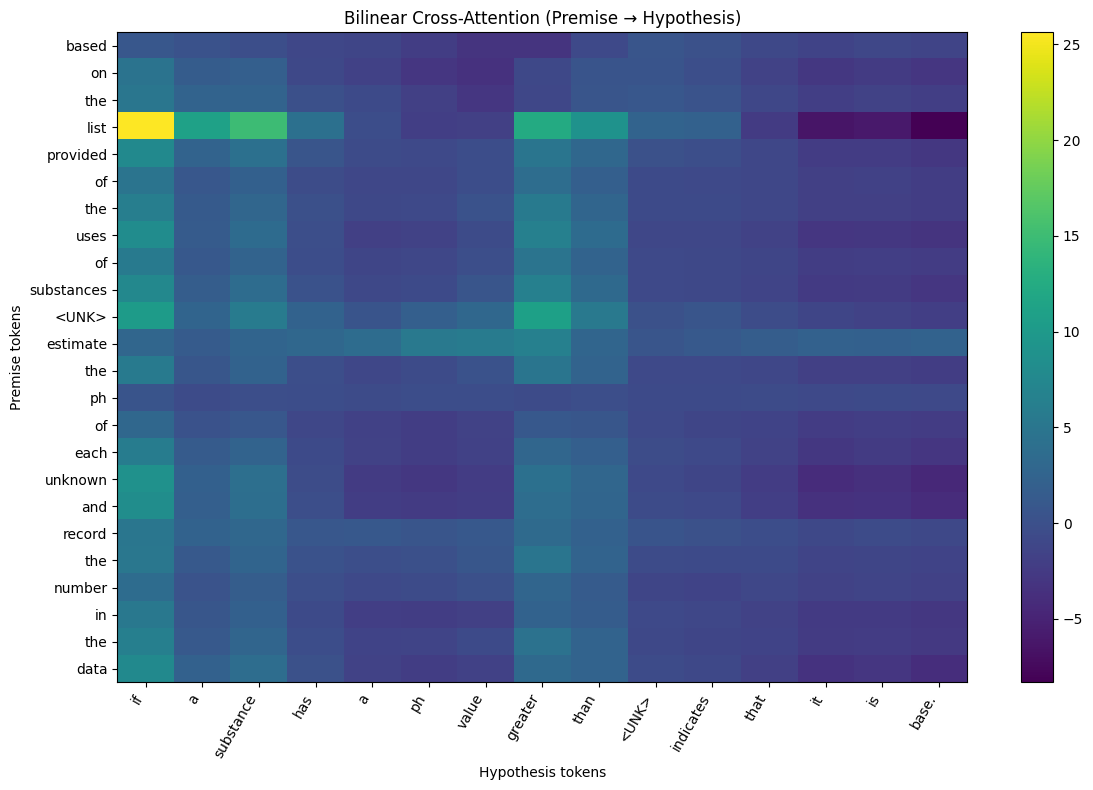

In [14]:

# =========================================================
# 7) Attention (Heatmap)
# =========================================================
def id2tok(seq_ids):
    inv = {i: w for w, i in word2id.items()}
    toks = []
    for i in seq_ids:
        if i == pad_id: break
        toks.append(inv.get(int(i), "<UNK>"))
    return toks


idx = 0
prem_ids = Xt_p[idx:idx+1]
hypo_ids = Xt_h[idx:idx+1]
S = attn_model.predict([prem_ids, hypo_ids], verbose=0)[0]   # [Lp, Lh]

prem_toks = id2tok(prem_ids[0])
hypo_toks = id2tok(hypo_ids[0])

Lp, Lh = len(prem_toks), len(hypo_toks)
S = S[:Lp, :Lh]

plt.figure(figsize=(min(12, 0.6*Lh+3), min(8, 0.5*Lp+3)))
plt.imshow(S, aspect="auto")
plt.colorbar()
plt.xticks(range(Lh), hypo_toks, rotation=60, ha="right")
plt.yticks(range(Lp), prem_toks)
plt.title("Bilinear Cross-Attention (Premise → Hypothesis)")
plt.xlabel("Hypothesis tokens")
plt.ylabel("Premise tokens")
plt.tight_layout()
plt.show()